# Preparations

In [ ]:
!pip install accelerate -Uq

exit()

In [ ]:
!pip install -q datasets transformers evaluate peft lion-pytorch adan-pytorch torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 17.4 MB/s eta 0:00:00


In [ ]:
from transformers import set_seed
import os
import random
import numpy as np

import torch

def set_all_seeds(seed=22):
    '''
    sets all random states to enforce reproducibility

    Parameters:
    -----------
        seed (int):
            random state to use
    '''

    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

magic_seed = 22
set_all_seeds(seed=magic_seed)

In [ ]:
from sklearn.metrics import cohen_kappa_score

def calculate_cohen_kappa(y_true, y_pred):
    '''
    calculates cohen's kappa score

    Parameters:
    -----------
        y_true:
            ground truth labels

        y_pred:
            predictions of the model

    Return:
    -------
        Cohen's kappa score
    '''
    return cohen_kappa_score(y_true.flatten(), y_pred.flatten())


In [ ]:
import torch
from torch import nn
import evaluate
from matplotlib import pyplot as plt

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    '''
    computes metrics on validation dataset from model's predictions

    Parameters:
    -----------
        eval_pred:
            tuple of (logits, labels), where logits is a output of the model
            and labels is the ground truth masks

    Return:
    -------
        metrics:
            metric values in the form of dict of format {'metric_name': metric_value}
    '''
    with torch.no_grad():
        logits, labels = eval_pred

        logits_tensor = torch.from_numpy(logits)

        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).detach().cpu().numpy()

        pred_labels = logits_tensor.argmax(axis=1)

        # currently using _compute instead of compute
        # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=False,#feature_extractor.do_reduce_labels,
            )

        eval_iou = metrics['per_category_iou'][1]
        metrics = {'eval_IoU': eval_iou}
        metrics['eval_Dice'] = eval_iou * 2 / (eval_iou + 1)
        metrics['eval_kappa_score'] = calculate_cohen_kappa(labels, pred_labels)

        '''
        fig, axs = plt.subplots(2, 6, figsize=(32, 32))

        for k in range(num_samples):
          axs[0, k].imshow(sample_images['image'][k], cmap='gray')
          axs[0, k].set_title('Real')
          axs[0, k].axis('off')
        # axs[0, k].subplot_adjust(hspace=10)

          axs[1, k].imshow(logits_tensor[k, 1, :, :], cmap='gray')
          axs[1, k].set_title('Output')
          axs[1, k].axis('off')
        # axs[1, k].subplot_adjust(hspace=10)
        '''
        # к сожалению,  получаю сообщение "Buffered data was truncated after reaching the output size limit"
        # и больше не вижу output. М. б. сделать clear_output?
        '''
        for k in range(num_samples):
          plt.subplot(2, 6, k+1)
          plt.imshow(sample_images['image'][k], cmap='gray')
          plt.title('Real')
          plt.axis('off')

          plt.subplot(2, 6, k+7)
          plt.imshow(logits_tensor[k, 1, :, :], cmap='gray')
          plt.title('Output')
          plt.axis('off')
        '''
      # plt.subplots_adjust(hspace=0, wspace=0)
      # plt.show()


        return metrics

In [ ]:
from datasets import load_dataset

# Load our saved dataset from HuggingFace
hf_dataset_identifier = "Mauregato/leaf_disease_segmentation"
dataset = load_dataset(hf_dataset_identifier)

In [ ]:
# Dataset structure
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 2205
    })
    val: Dataset({
        features: ['image', 'mask'],
        num_rows: 294
    })
    test: Dataset({
        features: ['image', 'mask'],
        num_rows: 441
    })
})

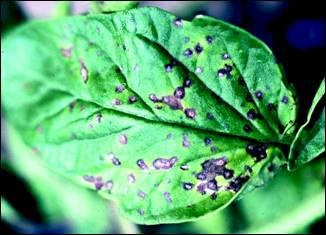

In [ ]:
dataset['train'][0]['image']

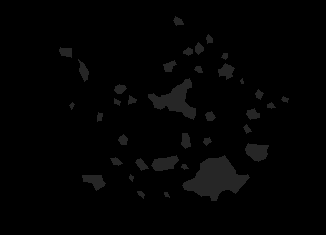

In [ ]:
dataset['train'][0]['mask']

In [ ]:
from huggingface_hub import hf_hub_download
import json

# Load json file from HuggingFace to initialize labels correctly
repo_id = "huggingface/label-files"
filename = "id2label.json"
id2label = json.load(
    open(hf_hub_download(hf_dataset_identifier, filename, repo_type="dataset"), "r")
)
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

id2label.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

In [ ]:
num_labels, list(label2id.keys())

(2, ['unlabeled', 'leaf-disease'])

In [ ]:
train_ds = dataset['train']
val_ds = dataset['val']
test_ds = dataset['test']

In [ ]:
# Samples to see results of training
num_samples = 6
sample_images = val_ds[:num_samples]

# SegFormerForSemanticSegmentation

In [ ]:
from transformers import SegformerImageProcessor, MobileViTImageProcessor, AutoImageProcessor

model_checkpoint =  "nvidia/mit-b2" #"apple/deeplabv3-mobilevit-small" # pre-trained model from which to fine-tune
feature_extractor = SegformerImageProcessor.from_pretrained(model_checkpoint, do_reduce_labels=False)


def train_transforms(example_batch):
    '''
    performs transforms on train batch

    Parameters:
    -----------
        example_batch:
            train batch to process

    Return:
    -------
        inputs:
            processed train batch
    '''

    images = [x for x in example_batch['image']]
    masks = [x for x in example_batch['mask']]

    inputs = feature_extractor(images, masks)

    all_masks = inputs['labels']
    # There are int values greater that 1 in some masks. Let's fix it.
    for mask in all_masks:
        mask[mask > 0] = 1
    inputs['labels'] = all_masks
    return inputs


def val_transforms(example_batch):
    '''
    performs transforms on validation batch

    Parameters:
    -----------
        example_batch:
            validation batch to process

    Return:
    -------
        inputs:
            processed validation batch
    '''

    images = [x for x in example_batch['image']]
    labels = [x for x in example_batch['mask']]

    inputs = feature_extractor(images, labels)
    all_masks = inputs['labels']
    # There are int values greater that 1 in some masks. Let's fix it.
    for mask in all_masks:
        mask[mask > 0] = 1
    inputs['labels'] = all_masks
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
from transformers import SegformerForSemanticSegmentation, MobileViTForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

## Freeze some layers

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
for param in model.decode_head.parameters():
    param.requires_grad = True # Будем обучать только декодер

#MobileViTForSemanticSegmentation

In [ ]:
from transformers import MobileViTImageProcessor

model_checkpoint =  "apple/deeplabv3-mobilevit-small" # pre-trained model from which to fine-tune
feature_extractor = MobileViTImageProcessor.from_pretrained(model_checkpoint)
new_x = feature_extractor.crop_size['width']
new_y = feature_extractor.crop_size['height']
def train_transforms(example_batch):
    '''
    performs transforms on train batch

    Parameters:
    -----------
        example_batch:
            train batch to process

    Return:
    -------
        inputs:
            processed train batch
    '''

    images = [x for x in example_batch['image']]
    masks = [x for x in example_batch['mask']]

    inputs = feature_extractor(images=images)

    processed_masks = []
    for mask in masks:
        mask = np.array(mask.resize((new_x, new_y)))
        mask[mask > 0] = 1
        processed_masks.append(mask)
    inputs['labels'] = np.array(processed_masks, dtype='long')

    return inputs


def val_transforms(example_batch):
    '''
    performs transforms on validation batch

    Parameters:
    -----------
        example_batch:
            validation batch to process

    Return:
    -------
        inputs:
            processed validation batch
    '''

    images = [x for x in example_batch['image']]
    masks = [x for x in example_batch['mask']]

    inputs = feature_extractor(images)

    processed_masks = []
    for mask in masks:
      mask = np.array(mask.resize((new_x, new_y)))
      mask[mask > 0] = 1
      processed_masks.append(mask)
    inputs['labels'] = np.array(processed_masks, dtype='long')

    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
from transformers import MobileViTForSemanticSegmentation

model = MobileViTForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

#LoRA

In [ ]:
def print_trainable_parameters(model):
    '''
    prints the number and the ratio of trainable parameters in the model.

    Parameters:
    -----------
        model:
            model to use for fine-tuning
    '''

    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}")

In [ ]:
print_trainable_parameters(model)

trainable params: 3714658 || all params: 3714658 || trainable%: 100.00


In [ ]:
from peft import LoraConfig, get_peft_model

# initialize LoRA configuration
config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 594946 || all params: 4306532 || trainable%: 13.81


In [ ]:
from transformers import TrainingArguments

# Define training hyperparameters

epochs = 10
lr = 0.00006
batch_size = 5

model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    output_dir=f"{model_name}-leaf-disease-lora",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=410,
    eval_steps=410,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=False,
    remove_unused_columns=False,
    label_names = ["labels"],
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

In [ ]:
# Start training procedure
trainer.train()

Step,Training Loss,Validation Loss,Iou,Dice,Kappa Score
410,0.226000,0.175812,0.697893,0.822069,0.717219
820,0.247200,0.152264,0.767439,0.868419,0.754115
1230,0.103200,0.141243,0.786995,0.880803,0.773035
1640,0.245300,0.135074,0.762408,0.865189,0.775469
2050,0.109600,0.131551,0.839557,0.912781,0.795302
2460,0.232300,0.125587,0.794556,0.885518,0.795363
2870,0.093100,0.121860,0.801429,0.889770,0.801478
3280,0.429900,0.120873,0.803995,0.891349,0.804347
3690,0.116800,0.119448,0.839041,0.912477,0.810877
4100,0.093700,0.118187,0.845120,0.916060,0.814495


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encoun

TrainOutput(global_step=4410, training_loss=0.1556328794211487, metrics={'train_runtime': 2338.5252, 'train_samples_per_second': 9.429, 'train_steps_per_second': 1.886, 'total_flos': 4.480729221169152e+17, 'train_loss': 0.1556328794211487, 'epoch': 10.0})

# UPerNet (Swin)

In [ ]:
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

model_checkpoint =  "openmmlab/upernet-swin-small" # pre-trained model from which to fine-tune
feature_extractor = AutoImageProcessor.from_pretrained(model_checkpoint, do_reduce_labels=False)

def train_transforms(example_batch):

    images = [x for x in example_batch['image']]
    masks = [x for x in example_batch['mask']]
    inputs = feature_extractor(images, masks)

    all_masks = inputs['labels']
    for mask in all_masks:
        mask[mask > 0] = 1
    inputs['labels'] = all_masks
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['image']]
    labels = [x for x in example_batch['mask']]

    inputs = feature_extractor(images, labels)

    all_masks = inputs['labels']
    for mask in all_masks:
      mask[mask > 0] = 1
    inputs['labels'] = all_masks
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
model = UperNetForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

Some weights of UperNetForSemanticSegmentation were not initialized from the model checkpoint at openmmlab/upernet-swin-small and are newly initialized because the shapes did not match:
- auxiliary_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- auxiliary_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 512, 1, 1]) in the checkpoint and torch.Size([2, 512, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Train

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

6357941

In [ ]:
from sklearn.metrics import cohen_kappa_score

def calculate_cohen_kappa(y_true, y_pred):
  return cohen_kappa_score(y_true.flatten(), y_pred.flatten())

In [ ]:
import torch
from torch import nn
import evaluate
from matplotlib import pyplot as plt

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred

    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).detach().cpu().numpy()

    pred_labels = logits_tensor.argmax(axis=1)

    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=False,
        )

    eval_iou = metrics['per_category_iou'][1]
    metrics = {'eval_IoU': eval_iou}
    metrics['eval_Dice'] = eval_iou * 2 / (eval_iou + 1)
    metrics['eval_kappa_score'] = calculate_cohen_kappa(labels, pred_labels)


    '''
    fig, axs = plt.subplots(2, 6, figsize=(32, 32))

    for k in range(num_samples):
      axs[0, k].imshow(sample_images['image'][k], cmap='gray')
      axs[0, k].set_title('Real')
      axs[0, k].axis('off')
     # axs[0, k].subplot_adjust(hspace=10)

      axs[1, k].imshow(logits_tensor[k, 1, :, :], cmap='gray')
      axs[1, k].set_title('Output')
      axs[1, k].axis('off')
     # axs[1, k].subplot_adjust(hspace=10)
    '''
    # к сожалению,  получаю сообщение "Buffered data was truncated after reaching the output size limit"
    # и больше не вижу output. М. б. сделать clear_output?
    '''
    for k in range(num_samples):
      plt.subplot(2, 6, k+1)
      plt.imshow(sample_images['image'][k], cmap='gray')
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(logits_tensor[k, 1, :, :], cmap='gray')
      plt.title('Output')
      plt.axis('off')
    '''
   # plt.subplots_adjust(hspace=0, wspace=0)
   # plt.show()


    return metrics

In [ ]:
from transformers import TrainingArguments, get_linear_schedule_with_warmup
from adan_pytorch import Adan
from lion_pytorch import Lion
from torch_optimizer import AdaBound, RAdam, Yogi, Lamb
from torch.optim import AdamW

epochs = 10
lr = 0.00006
batch_size = 5

num_warmup_steps = 0
num_training_steps = len(train_ds) // batch_size * epochs

optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

hub_model_id = "segformer-b2-finetuned-leaf-disease"

training_args = TrainingArguments(
    "segformer-b2-finetuned-leaf-disease",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=100,
    eval_steps=100,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model='eval_IoU',
    greater_is_better=True,
    push_to_hub=False,
    remove_unused_columns=False,
    seed=magic_seed, # Хорошо бы сделать так. Однако по умолчанию уже используется seed=42, так что, может быть, и ладно
    hub_model_id=hub_model_id,
    hub_private_repo=True, # MUST HAVE!!!

    hub_strategy="end",
)

In [ ]:
from transformers import Trainer, default_data_collator

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Iou,Dice,Kappa Score
100,0.098700,0.164649,0.763276,0.865748,0.751643
200,0.153500,0.135385,0.778823,0.875661,0.782759
300,0.079700,0.116856,0.799389,0.888512,0.811032
400,0.089500,0.109355,0.793457,0.884835,0.819037
500,0.086300,0.106932,0.821167,0.901803,0.825537
600,0.042800,0.095701,0.866923,0.928718,0.851634
700,0.081300,0.086076,0.882576,0.937626,0.869188
800,0.067000,0.085046,0.916275,0.956309,0.867503
900,0.058500,0.084197,0.848421,0.917995,0.865262
1000,0.061200,0.080497,0.907924,0.951740,0.874955


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encoun

# Push model to hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer.push_to_hub('segformer-b2-finetuned-lead-disease')

events.out.tfevents.1713805486.27f4e1cc0d51.855.5:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Mauregato/segformer-b2-finetuned-leaf-disease/commit/a4589292d1c0a337d5dc6400cdbe6c18efd5d1da', commit_message='segformer-b0-finetuned-lead-disease', commit_description='', oid='a4589292d1c0a337d5dc6400cdbe6c18efd5d1da', pr_url=None, pr_revision=None, pr_num=None)

# Inference/test set

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Load model directly
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

processor = AutoImageProcessor.from_pretrained("Mauregato/segformer-b2-finetuned-leaf-disease")
model = SegformerForSemanticSegmentation.from_pretrained("Mauregato/segformer-b2-finetuned-leaf-disease")


preprocessor_config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = model.to(device)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 5
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

In [ ]:
from random import randint
from tqdm.auto import tqdm
import torch.nn as nn

kappa_score = 0
with torch.no_grad():
  for batch in tqdm(test_loader):
    pix_vals = batch['pixel_values'].to(device)
    labels = batch['labels']

    outputs = model(pixel_values=pix_vals)
    logits = outputs.logits.cpu()

    upsampled_logits = nn.functional.interpolate(
    logits,
    size=labels.shape[-2:],
    mode="bilinear",
    align_corners=False,)

    pred_seg = upsampled_logits.argmax(dim=1)
    metric.add_batch(predictions=pred_seg, references=labels)
    kappa_score += calculate_cohen_kappa(y_true=labels, y_pred=pred_seg)

kappa_score /= len(test_loader)


  0%|          | 0/89 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible 

In [ ]:
test_iou = metric.compute(num_labels=len(id2label),
               ignore_index=0, reduce_labels=processor.do_reduce_labels)['per_category_iou'][1]

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [ ]:
test_dice = test_iou * 2 / (test_iou + 1)

In [ ]:
print(f'test_iou = {test_iou}, test_dice = {test_dice}, test_kappa = {kappa_score}') # Для segformer-b2

test_iou = 0.9339953695139761, test_dice = 0.965871360642083, test_kappa = 0.8594076130138166


In [ ]:
# Результаты на тестовом множестве

# SegFormer-b2
'''
IoU = 0.9339953695139761,
Dice = 0.965871360642083,
Kappa = 0.8594076130138166
'''

  0%|          | 0/45 [00:00<?, ?it/s]

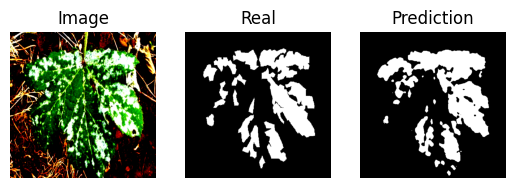

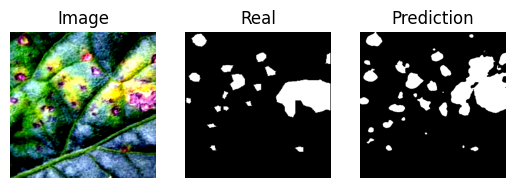

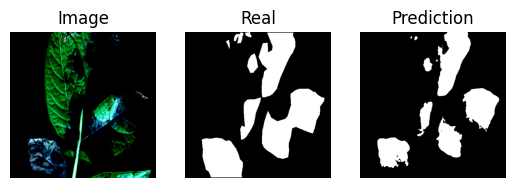

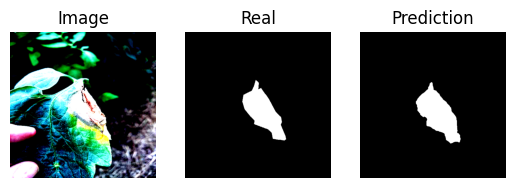

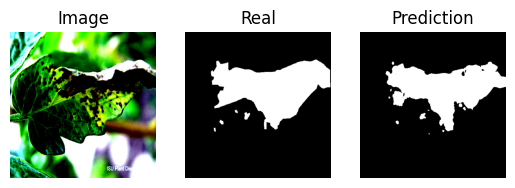

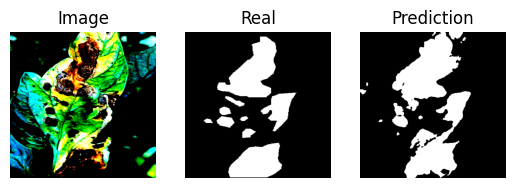

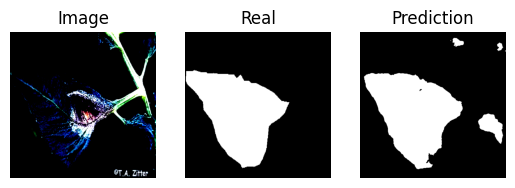

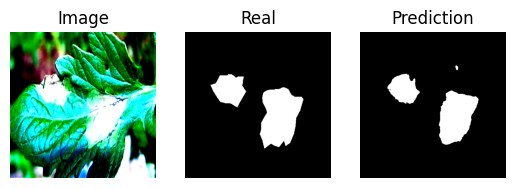

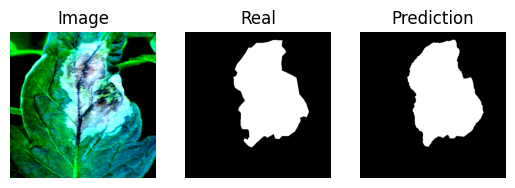

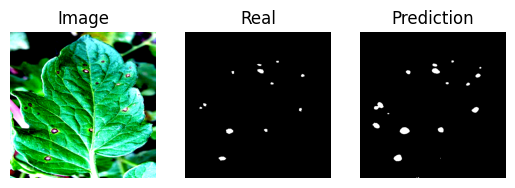

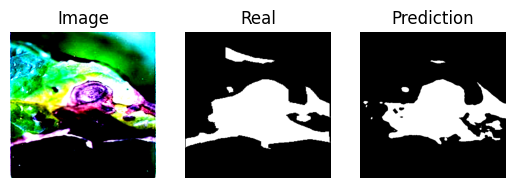

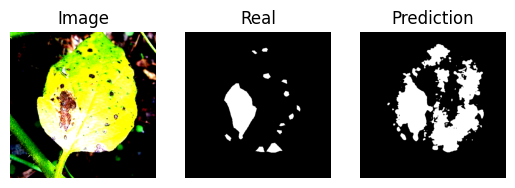

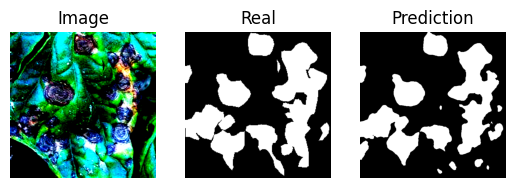

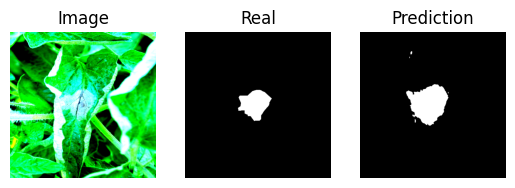

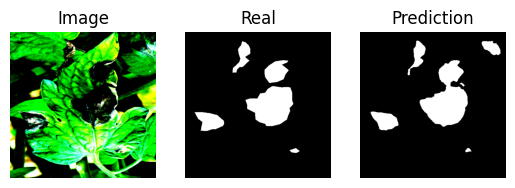

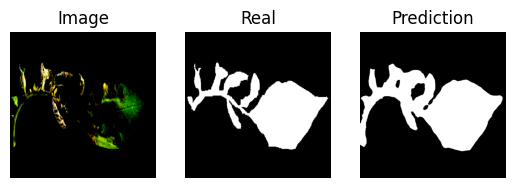

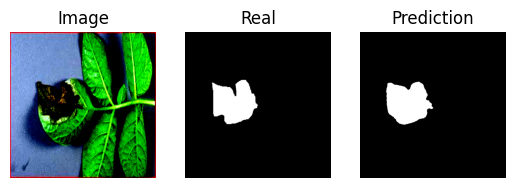

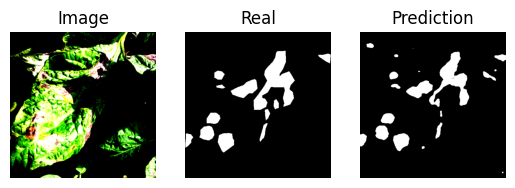

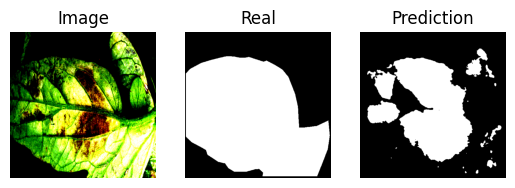

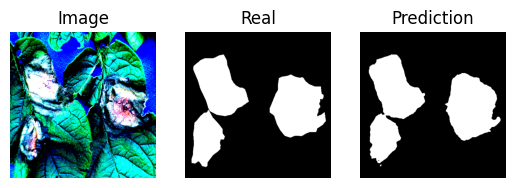

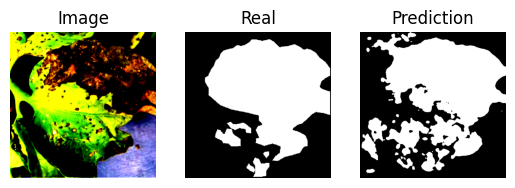

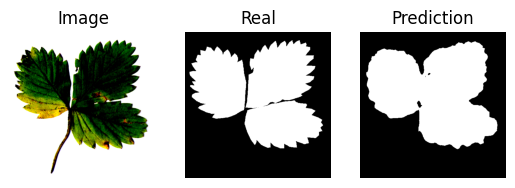

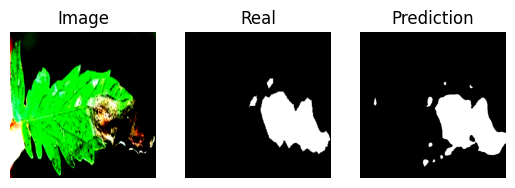

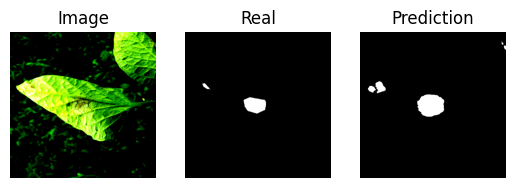

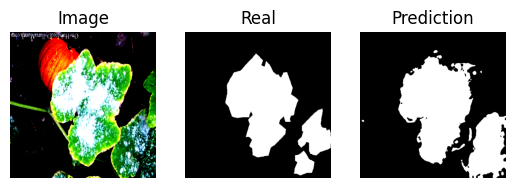

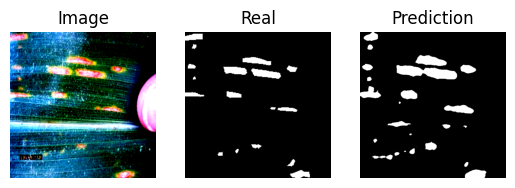

In [ ]:
from random import randint
from tqdm.auto import tqdm
with torch.no_grad():
  for batch in tqdm(test_loader):
    pix_vals = batch['pixel_values'].to(device)
    labels = batch['labels']

    outputs = model(pixel_values=pix_vals)
    logits = outputs.logits.cpu()

    upsampled_logits = nn.functional.interpolate(
    logits,
    size=labels.shape[-2:],
    mode="bilinear",
    align_corners=False,)

    pred_seg = upsampled_logits.argmax(dim=1)
    metric.add_batch(predictions=pred_seg, references=labels)

    rand_k = randint(0, pix_vals.shape[0] - 1)



    plt.subplot(1, 3, 1)
    plt.imshow(pix_vals[rand_k].cpu().permute((1, 2, 0)))
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(labels[rand_k], cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_seg[rand_k], cmap='gray')
    plt.title('Prediction')
    plt.axis('off')

    plt.show()


In [ ]:
metric.compute(num_labels=len(id2label),
               ignore_index=0, reduce_labels=feature_extractor.do_reduce_labels)